It's interesting to note that in deep learning, the evolution of architecture and techniques is very rapid, but that certain aspects can remain present for years in bits of code, without really knowing if they are totally necessary. Most of the time, we take for granted that these were optimized and this should not be taken care of.

One such aspect is *input normalization*, which is used as input to most convolutional neural networks (CNNs) used to process visual images. This is all the more true as we often use in the community networks that are pre-trained for images normalized to given values, like VGG or ResNET. When you ask Github's copilot, it says that 

>    Image normalization in convolutional neural networks (CNNs) has several beneficial effects:
>    1- Improved convergence: Normalization helps to stabilize and speed up the learning process by ensuring that pixel values are in a similar range, thus facilitating optimization.
>    2- Reduced sensitivity to scale variations: Normalizing images reduces the model's sensitivity to scale variations in pixel values, which can improve model robustness.
>    3- Prevention of neuron saturation: Unnormalized pixel values can lead to neuron saturation, which slows down learning. Normalization helps prevent this problem.
>    4- Improved performance: In general, image normalization can lead to better model performance in terms of accuracy and generalization.


**I'm interested here in whether these networks remain effective when we change the input normalization.** Indeed, as the weights of the first convolutional layer are learned, and as convolution kernels can be multiplied by arbitrary values thanks to the bias in the convolutions, normalizing to a certain value makes no sense, and simply normalizing does. This is even more evident when that values are given with 3 digits of precision! I propose here to show quantitatively that this is the case, first for a *historical* network [LeNet](https://en.wikipedia.org/wiki/LeNet) applied to the MNIST challenge, and then for [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network) applied to ImageNet.


<!-- TEASER_END -->

Let's first initialize the notebook:

In [2]:
import numpy as np
np.set_printoptions(precision=6, suppress=True)
import os

import matplotlib.pyplot as plt
phi = (np.sqrt(5)+1)/2
fig_width = 10
figsize = (fig_width, fig_width/phi)

In [3]:
%pip install -Uq -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [4]:
%mkdir -p data

# The MNIST challenge and the *French Touche* 

First, let's explore the *LeNet* network  (Lecun, Y.; Bottou, L.; Bengio, Y.; Haffner, P. (1998). "Gradient-based learning applied to document recognition" (PDF). Proceedings of the IEEE. 86 (11): 2278–2324. doi:10.1109/5.726791. S2CID 14542261), whose objective is to categorize images of written digits, one of the first great successes of Multilayer neural networks. For this one, we're going to use the classic implementation, as proposed in the PyTorch library example series. 

The cell below allows you to do everything: first load the libraries, then define the neural network, and finally define the learning and testing procedures that are applied to the database. The output accuracy value corresponds to the percentage of letters that are correctly classified.

In this cell, we'll isolate the two parameters used to set the mean and standard deviation applied to the normalization function, which we'll be manipulating in the course of this book.

In [5]:
# adapted from https://raw.githubusercontent.com/pytorch/examples/refs/heads/main/mnist/main.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

epochs = 15

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if verbose and batch_idx % log_interval  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)


def main(mean, std, weight_init=None, bias_init=None, epochs=epochs, log_interval=100, verbose=False):
    # Training settings
    torch.manual_seed(1998) # FOOTIX rules !
    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if torch.cuda.is_available():
        device = torch.device("cuda")
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    if mean is None:
        transform = transforms.ToTensor()
    else:
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))
            ])
    dataset1 = datasets.MNIST('data', train=True, download=True,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)

    dataset2 = datasets.MNIST('data', train=False,
                       transform=transform)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)

    if not bias_init is None:
        model.conv1.bias.data *= bias_init
    if not weight_init is None:
        model.conv1.weight.data *= weight_init

    
    optimizer = optim.Adadelta(model.parameters(), lr=1.0)
    # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    scheduler = ReduceLROnPlateau(optimizer, 'max')
    for epoch in range(1, epochs+1):
        train(model, device, train_loader, optimizer, epoch, log_interval=log_interval, verbose=verbose)
        accuracy = test(model, device, test_loader, verbose=verbose)
        scheduler.step(accuracy)

    if verbose: print(f'The std of weight and bias in the first convolutional layer is {model.conv1.weight.std().item():.4f} and  {model.conv1.bias.std().item():.4f}')
    return accuracy



You can notice that I made one change by using the `ReduceLROnPlateau` scheduler instead of `StepLR`. In practice, this only changed the values I could test - run the notebook with enough epochs and the other scheduler to make your own opinion.

Now that we've defined the entire protocol, we can test it in its most classic form, as delivered in the original code with 3 digits precision (!) :

In [5]:
accuracy = main(mean=0.1307, std=0.3081, verbose=True)
print(f'{accuracy=:.4f}')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304624


Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.281178


Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.516990


Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.337506


Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.121790


Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.234445


Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.017113


Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.092789


Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.033573


Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.037385



Test set: Average loss: 0.0488, Accuracy: 9835/10000 (98%)



Train Epoch: 2 [0/60000 (0%)]	Loss: 0.011028


Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.019014


Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.109865


Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.011582


Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.071201


Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.243998


Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.004943


Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.009630


Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.019085


Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.169219



Test set: Average loss: 0.0524, Accuracy: 9841/10000 (98%)



Train Epoch: 3 [0/60000 (0%)]	Loss: 0.031327


Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.007718


Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.141368


Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.009250


Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.006876


Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.004360


Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.116086


Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.072313


Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.049017


Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.024332



Test set: Average loss: 0.0335, Accuracy: 9883/10000 (99%)



Train Epoch: 4 [0/60000 (0%)]	Loss: 0.029007


Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.009332


Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.030628


Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.133142


Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.054411


Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.004071


Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.071450


Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.145187


Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.001773


Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.106237



Test set: Average loss: 0.0357, Accuracy: 9893/10000 (99%)



Train Epoch: 5 [0/60000 (0%)]	Loss: 0.004570


Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.011164


Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.150560


Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.038758


Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.029160


Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.079308


Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.099629


Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.024790


Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.068315


Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.010813



Test set: Average loss: 0.0322, Accuracy: 9913/10000 (99%)



Train Epoch: 6 [0/60000 (0%)]	Loss: 0.019584


Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.003815


Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.023842


Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.007701


Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.013744


Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.007003


Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.004972


Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.045177


Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.006468


Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.043661



Test set: Average loss: 0.0335, Accuracy: 9910/10000 (99%)



Train Epoch: 7 [0/60000 (0%)]	Loss: 0.053785


Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.172224


Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.010990


Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.019810


Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000504


Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.036467


Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.009506


Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.007829


Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.047448


Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.008582



Test set: Average loss: 0.0326, Accuracy: 9907/10000 (99%)



Train Epoch: 8 [0/60000 (0%)]	Loss: 0.081056


Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.002920


Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000405


Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.002494


Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.040551


Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.004167


Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.006152


Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.006185


Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.043025


Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.039717



Test set: Average loss: 0.0355, Accuracy: 9914/10000 (99%)



Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000495


Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.059491


Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.018307


Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.046228


Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.019544


Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.090836


Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.011259


Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.198908


Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.135459


Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.035063



Test set: Average loss: 0.0344, Accuracy: 9905/10000 (99%)



Train Epoch: 10 [0/60000 (0%)]	Loss: 0.005601


Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.023362


Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000109


Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.001192


Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.017619


Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.118632


Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.033162


Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.015616


Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.004130


Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.085506



Test set: Average loss: 0.0361, Accuracy: 9905/10000 (99%)



Train Epoch: 11 [0/60000 (0%)]	Loss: 0.009951


Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.001097


Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.013806


Train Epoch: 11 [19200/60000 (32%)]	Loss: 0.001884


Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.004637


Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.001132


Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.018414


Train Epoch: 11 [44800/60000 (75%)]	Loss: 0.044070


Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.005729


Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.000434



Test set: Average loss: 0.0371, Accuracy: 9914/10000 (99%)



Train Epoch: 12 [0/60000 (0%)]	Loss: 0.035833


Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.089021


Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.000297


Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.001390


Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.038403


Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.001352


Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.032815


Train Epoch: 12 [44800/60000 (75%)]	Loss: 0.000634


Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.001752


Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.023597



Test set: Average loss: 0.0392, Accuracy: 9915/10000 (99%)



Train Epoch: 13 [0/60000 (0%)]	Loss: 0.057553


Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.007608


Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.001990


Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.001200


Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.002984


Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.003028


Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.002459


Train Epoch: 13 [44800/60000 (75%)]	Loss: 0.001298


Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.000040


Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.040002



Test set: Average loss: 0.0401, Accuracy: 9911/10000 (99%)



Train Epoch: 14 [0/60000 (0%)]	Loss: 0.048102


Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.000400


Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.005354


Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.059465


Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.030267


Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.002058


Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.000379


Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.086048


Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.043677


Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.004139



Test set: Average loss: 0.0335, Accuracy: 9914/10000 (99%)



Train Epoch: 15 [0/60000 (0%)]	Loss: 0.005576


Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.005919


Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.080235


Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.097650


Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.000275


Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.014443


Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.013720


Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.025643


Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.001456


Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.015662



Test set: Average loss: 0.0382, Accuracy: 9898/10000 (99%)

The std of weight and bias in the first convolutional layer is 0.2198 and  0.1032
accuracy=0.9898


These exact same numbers were first introduced in that code on [Jan 17, 2017](https://github.com/pytorch/examples/commit/32c7386aef93737926069ee284d827f8e954e086) and these exact values have not changed since (up to the 3rd digit).

One advantage of our code is that we can now manipulate these two values, to see if starting from a different tuple of numbers, we obtain an accuracy value that is different.



Let's first see what happens without normalization:

In [6]:
accuracy = main(mean=None, std=None)
print(f'{accuracy=:.4f}')

accuracy=0.9913


Pretty much the same...

What if we use standard numbers?

In [7]:
accuracy = main(mean=0., std=1.)
print(f'{accuracy=:.4f}')

accuracy=0.9906


The result seems similar, but it's not enough to demonstrate that the mean and standard deviation have no effect on learning.

## computing accuracy on a regular grid of values

I'm now going to push the boat out further, using a library that allows me to test several values and thus optimize the parameters. If the mean and deviation are so important, we'll converge on a fixed set of values, whereas if they're less important, the values can be quite scattered. In particular, this will allow us to choose an arbitrary value, such as a mean of 0 and a standard deviation of 1, better known as *normal* normalization.

In [8]:
# %rm {path_save_numpy}

In [6]:
model = 'LeNet'
epochs = 30 # a bit more than the original example which had 15 epochs
N_scan = 15

means = np.linspace(-2, 3., N_scan, endpoint=True)
stds = np.geomspace(0.02, 2., N_scan, endpoint=True)

path_save_numpy =  f'numpy-{model}.npy'
if not(os.path.isfile(path_save_numpy)):
    accuracy = np.empty((N_scan, N_scan))
    for i_mean, mean in enumerate(means):
        for i_std, std in enumerate(stds):
            accuracy[i_mean, i_std] = main(mean=mean, std=std, epochs=epochs)
    np.save(path_save_numpy, accuracy)
else:
    print(f'Loading {path_save_numpy}')
    accuracy = np.load(path_save_numpy)    

Loading numpy-LeNet.npy


/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_16226/4244923449.py:2: UserWarning: The following kwargs were not used by contour: 'n'
  CS = ax.contourf(means, stds, accuracy, n=20, cmap='viridis')


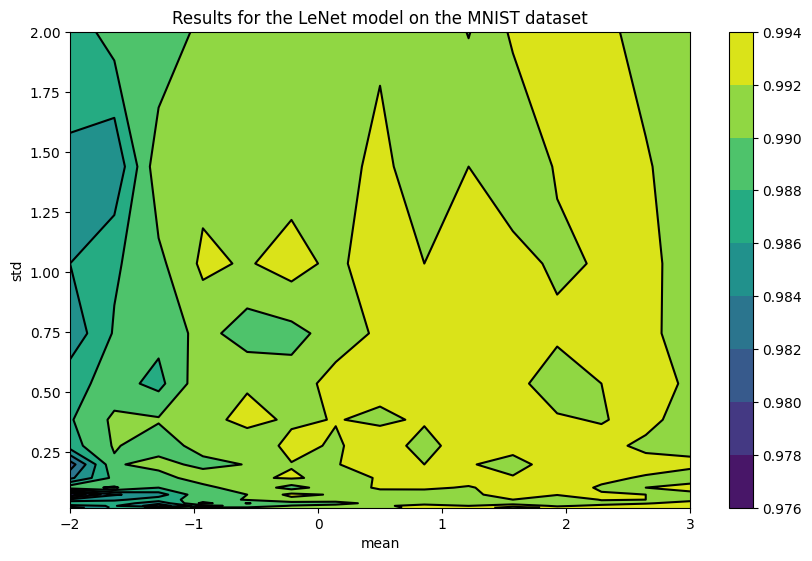

In [13]:
fig, ax = plt.subplots(figsize=figsize)
CS = ax.contourf(means, stds, accuracy, n=20, cmap='viridis')
CS2 = ax.contour(CS, levels=CS.levels, colors='k')
fig.colorbar(CS, ax=ax, extendfrac=0)
ax.set_title('Results for the LeNet model on the MNIST dataset')
ax.set_xlabel('mean')
ax.set_ylabel('std')
fig;

One is most certainly interested by the best value:

In [14]:
mean_max, std_max = np.unravel_index(np.argmax(accuracy), accuracy.shape)
print(f'Optimal value at indicies {mean_max, std_max}, with accuracy {accuracy[mean_max, std_max]:.4f}')

Optimal value at indicies (12, 7), with accuracy 0.9936


In [15]:
print(f'Optimal value: of mean={means[mean_max]:.4f}, std={stds[std_max]:.4f}')

Optimal value: of mean=2.2857, std=0.2000


Or by the barycenter of the accuracy map:

In [16]:
print(f'Center of gravity: {np.sum(means*accuracy)/np.sum(accuracy):.4f}, {np.sum(stds*accuracy)/np.sum(accuracy):.4f}')

Center of gravity: 0.5026, 0.4728


There is a low variabilty of the accuracy:

In [17]:
print(f'Variabity of accuracy: {np.std(accuracy):.4f}')

Variabity of accuracy: 0.0025


Mostly driven by the worst value:

In [18]:
mean_min, std_min = np.unravel_index(np.argmin(accuracy), accuracy.shape)
print(f'Worst value at indicies {mean_min, std_min}, with accuracy {accuracy[mean_min, std_min]:.4f}')

Worst value at indicies (4, 0), with accuracy 0.9779


In [19]:
print(f'Worst value: of mean={means[mean_min]:.4f}, std={stds[std_min]:.4f}')

Worst value: of mean=-0.5714, std=0.0200


The variability on the plateau is very low:

In [20]:
accuracy_best95 = accuracy[accuracy >np.percentile(accuracy, .05)].flatten()
print(f'Variabity of accuracy: {np.std(accuracy_best95):.4f}')

Variabity of accuracy: 0.0023


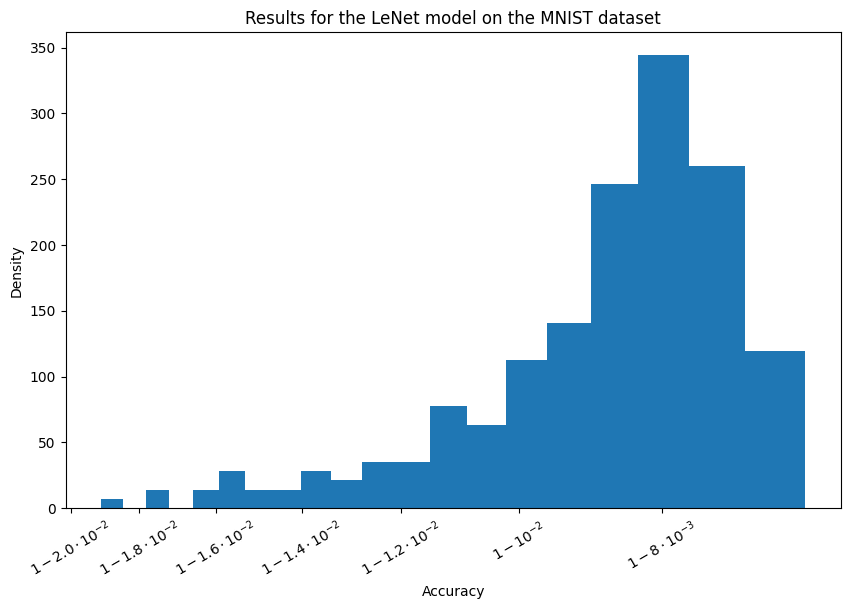

In [21]:
fig, ax = plt.subplots(figsize=figsize)
ax.hist(accuracy_best95, bins=20, density=True)
ax.set_title('Results for the LeNet model on the MNIST dataset')
ax.set_xlabel('Accuracy')
ax.set_xscale('logit')
plt.xticks(rotation=30)
ax.set_ylabel('Density')
fig;

Such that we can confidently say that we do not need a 3 digits initialization

In [22]:
accuracy = main(mean=0.5, std=0.5, verbose=False)
print(f'{accuracy=:.4f}')

KeyboardInterrupt: 

## using optuna to search on a non-regular grid of values

I'm now going to push the boat out further, using a library that allows me to test several values and thus optimize the parameters. If the mean and deviation are so important, we'll converge on a fixed set of values, whereas if they're less important, the values can be quite scattered. In particular, this will allow us to choose an arbitrary value, such as a mean of 0 and a standard deviation of 1, better known as *normal* normalization.

In [23]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [24]:
path_save_optuna =  f'optuna-{model}.sqlite3'
print(f'-> file {path_save_optuna} exists: {os.path.isfile(path_save_optuna)}')

-> file optuna-LeNet.sqlite3 exists: True


In [25]:
n_trials = 200

In [26]:
# %rm {path_save_optuna}

In [27]:
def objective(trial):
    mean = trial.suggest_float('mean', -1, 2., log=False)
    std = trial.suggest_float('std', 0.05, 1., log=True)
    accuracy = main(mean=mean, std=std, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model)
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'mean': 0.1440116283993092, 'std': 0.5690034868978842}
Best value:  0.9935


/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_16226/2318167149.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
[W 2024-12-24 08:25:41,840] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


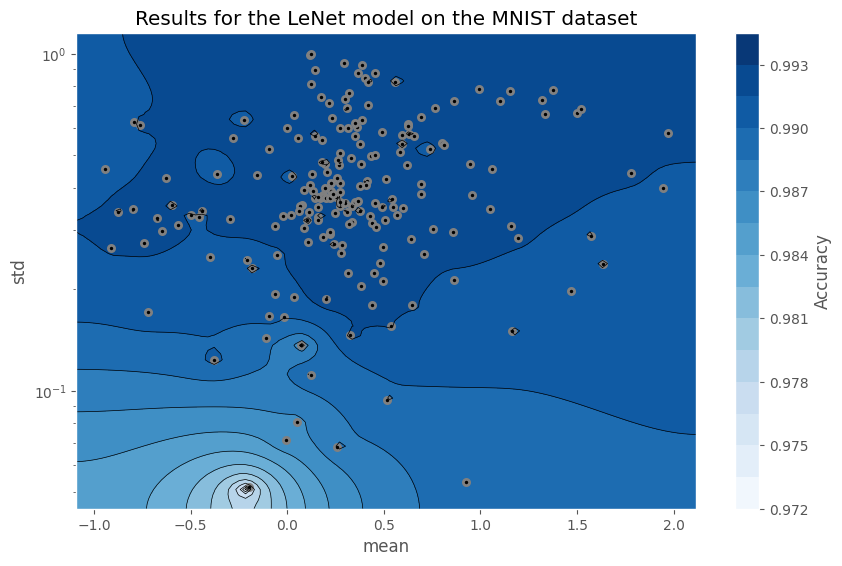

In [28]:
# https://optuna.readthedocs.io/en/stable/reference/visualization/matplotlib/generated/optuna.visualization.matplotlib.contour.html
from optuna.visualization.matplotlib import plot_contour

ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
fig = plt.gcf()
ax.set_title('Results for the LeNet model on the MNIST dataset')
fig.set_size_inches(figsize[0], figsize[1])

But wait, where do these values come from? How are layer weights and biases initialized by default?

For [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) and  [nn.conv2D](https://pytorch.org/docs/stable/generated/torch.ao.nn.quantized.Conv2d.html), the weights are initialized from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$, where $k = \frac{1}{\text{in\_features}}$ for the linear layer and $k = \frac{1}{C_\text{in} * \prod_{i=0}^{1}\text{kernel\_size}[i]}$.

This is performed by [Glorot initialization](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) :


In [29]:
conv1 = nn.Conv2d(1, 32, 3, 1)
print(f'The mean of weight and bias in the first convolutional layer is {conv1.weight.mean().item():.4f} and  {conv1.bias.mean().item():.4f}')
print(f'The std of weight and bias in the first convolutional layer is {conv1.weight.std().item():.4f} and  {conv1.bias.std().item():.4f}')
print(f' k= {1/3/3/1:.4f}, sqrt(k) = {np.sqrt(1/3/3/1):.4f}$')


The mean of weight and bias in the first convolutional layer is 0.0220 and  0.0625
The std of weight and bias in the first convolutional layer is 0.1886 and  0.1877
 k= 0.1111, sqrt(k) = 0.3333$


## using optuna to search for another initialization point


But wait, where do these values come from? How are layer weights and biases initialized by default?

For [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) and  [nn.conv2D](https://pytorch.org/docs/stable/generated/torch.ao.nn.quantized.Conv2d.html), the weights and biases are initialized from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$, where $k = \frac{1}{\text{in\_features}}$ for the linear layer and $k = \frac{1}{C_\text{in} * \prod_{i=0}^{1}\text{kernel\_size}[i]}$.

Let's see if for a given value of `mean=0` and `std=1`, we can optimize 


In [30]:
def objective(trial):
    weight_init = trial.suggest_float('weight_init', 0.05, 20., log=True)
    bias_init = trial.suggest_float('bias_init', 0.05, 20., log=True)
    accuracy = main(mean=-1, std=0.1, weight_init=weight_init, bias_init=bias_init, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model + '-init_WB')
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'weight_init': 0.307155100974441, 'bias_init': 5.5455929037599185}
Best value:  0.9941


# The ImageNet challenge and *residual networks* 

Second, let's tackle a real world problem: image classification with 1 million images and 1000 labels. For this we will use the well-known Resnet model defined in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) as it givves a nice balance between simplicity and performance. In general, [Residual neural networks](https://en.wikipedia.org/wiki/Residual_neural_network) are widely used architectures for feed-forward networks and 

The cell below allows you to do everything: first load the libraries, then define the neural network, and finally define the learning and testing procedures that are applied to the database. The output accuracy value corresponds to the percentage of images that are correctly classified. To simplify things, we will use pretrained weights and the retraining protocol which were used in [Jean-Nicolas Jérémie, Laurent U Perrinet (2023). Ultra-Fast Image Categorization in biology and in neural models.](https://laurentperrinet.github.io/publication/jeremie-23-ultra-fast-cat/) and available in the following code [UltraFastCat.ipynb](https://nbviewer.org/github/JNJER/2022-03_UltraFastCat/blob/main/UltraFastCat.ipynb)

In this cell, we'll isolate the two parameters used to set the mean and standard deviation applied to the normalization function, which we'll be manipulating in the course of this book. Since we have colored images, that is, 3 channels, it means we manipulate 6 variables.

https://pytorch.org/hub/pytorch_vision_resnet/

In [31]:
import torch
from torchvision.models import ResNet18_Weights

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.DEFAULT)
# or any of these variants 'resnet34', 'resnet50', 'resnet101', 'resnet152',
model

Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
epochs = 1

def train(model, device, train_loader, criterion, optimizer, epoch, log_interval=100, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if verbose and batch_idx % log_interval  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    if verbose:
        print('\nTest set: Av Accuracy: {}/{} ({:.0f}%)\n'.format(
            correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)

def main(mean_R, mean_G, mean_B, std_R, std_G, std_B, epochs=epochs, log_interval=100, verbose=False):
    # Training settings
    torch.manual_seed(1998) # FOOTIX rules !
    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if torch.cuda.is_available():
        device = torch.device("cuda")
        cuda_kwargs = {'num_workers': 1,
                    #    'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((mean_R, mean_G, mean_B), (std_R, std_G, std_B))
        ])
    
    DATADIR = '../Deep_learning/data/Imagenet_redux'
    DATADIR = '/home/laurent/app54_nextcloud/2024_archives/2024_science/Deep_learning/data/Imagenet_full'
    train_loader = torch.utils.data.DataLoader(datasets.ImageFolder(DATADIR + '/train', transform=transform), **train_kwargs)
    test_loader = torch.utils.data.DataLoader(datasets.ImageFolder(DATADIR + '/val', transform=transform), **test_kwargs)

    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.DEFAULT, verbose=False)
    model = model.to(device)

    # model.conv1.bias.data -= mean
    # model.conv1.weight.data /= std

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adadelta(model.parameters(), lr=1.0)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(1, epochs):
        train(model, device, train_loader, criterion, optimizer, epoch, log_interval=log_interval, verbose=verbose)
        scheduler.step()

    accuracy = test(model, device, test_loader, verbose=verbose)
    return accuracy


Now that we've defined the entire protocol, we can test it in its most classic form, as delivered in the original code by 6 numbers with 3 digits precision:

In [30]:
accuracy = main(0.485, 0.456, 0.406, 0.229, 0.224, 0.225)
print(f'{accuracy=:.4f}')

accuracy=0.6976


What does it yield with normal parameters?

In [31]:
accuracy = main(0., 0., 0., 1., 1., 1.)
print(f'{accuracy=:.4f}')

accuracy=0.4482


Let's scan the parameters:

In [36]:
model = 'ResNet'

In [37]:
N_scan = 15
means = np.linspace(-3, 3, N_scan, endpoint=True)
stds = np.geomspace(0.05, 1., N_scan, endpoint=True)

path_save_numpy =  f'numpy-{model}.npy'
if not(os.path.isfile(path_save_numpy)):
    accuracy = np.empty((N_scan, N_scan))
    for i_mean, mean in enumerate(means):
        for i_std, std in enumerate(stds):
            accuracy[i_mean, i_std] = main(mean, mean, mean, std, std, std, epochs=epochs)

    np.save(path_save_numpy, accuracy)
else:
    accuracy = np.load(path_save_numpy)

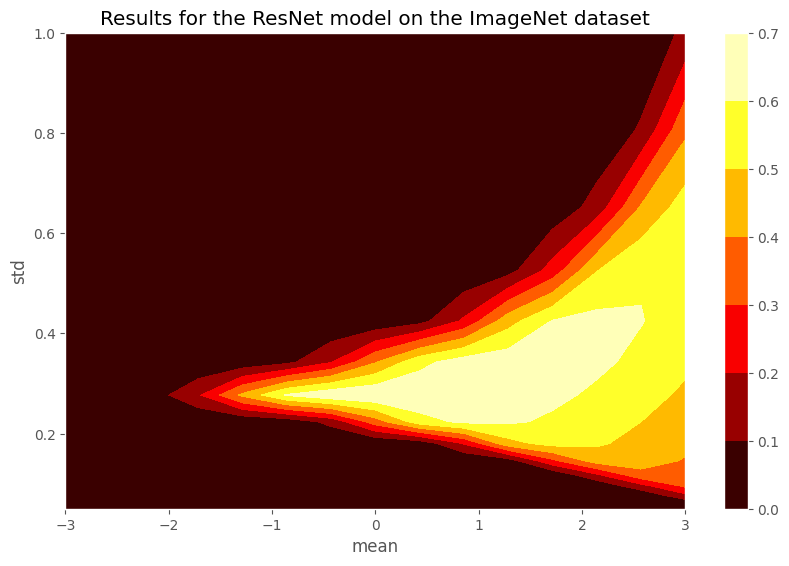

In [38]:
fig, ax = plt.subplots(figsize=figsize)
pcm = ax.contourf(means, stds, accuracy, cmap='hot')
fig.colorbar(pcm, ax=ax)
ax.set_title('Results for the ResNet model on the ImageNet dataset')
ax.set_xlabel('mean')
ax.set_ylabel('std')
fig;

Let's zoom around the central region

In [ ]:
N_scan = 15
means = np.linspace(-.5, 1.5, N_scan, endpoint=True)
stds = np.geomspace(0.20, 0.6, N_scan, endpoint=True)

path_save_numpy =  f'numpy-{model}-zoom.npy'
if not(os.path.isfile(path_save_numpy)):
    accuracy = np.empty((N_scan, N_scan))
    for i_mean, mean in enumerate(means):
        for i_std, std in enumerate(stds):
            accuracy[i_mean, i_std] = main(mean, mean, mean, std, std, std, epochs=epochs)

    np.save(path_save_numpy, accuracy)
else:
    accuracy = np.load(path_save_numpy)

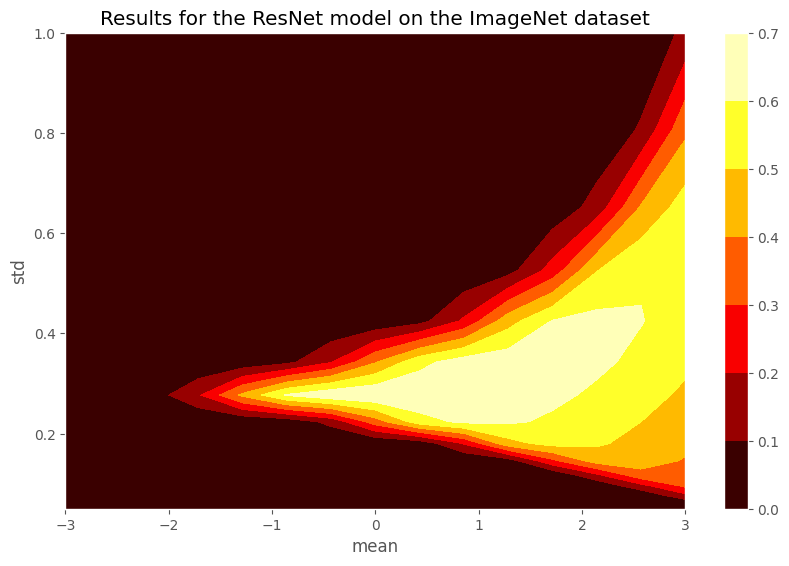

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
pcm = ax.contourf(means, stds, accuracy, cmap='hot')
fig.colorbar(pcm, ax=ax)
ax.set_title('Results for the ResNet model on the ImageNet dataset')
ax.set_xlabel('mean')
ax.set_ylabel('std')
fig;

And now with optuna:

In [39]:
path_save_optuna =  f'optuna-{model}.sqlite3'

In [40]:
# %rm {path_save_optuna}

In [ ]:
def objective(trial):
    mean = trial.suggest_float('mean', -.5, 1.5, log=False)
    std = trial.suggest_float('std', 0.20, 0.6, log=True)
    accuracy = main(mean, mean, mean, std, std, std, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model)
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'mean': 0.46812841381944315, 'std': 0.23841314189679977}
Best value:  0.69396


In [42]:
path_save_optuna, len(study.get_trials())

('optuna-ResNet.sqlite3', 200)

In [43]:
study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)

/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_16226/1797386942.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
[W 2024-12-24 08:28:15,696] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


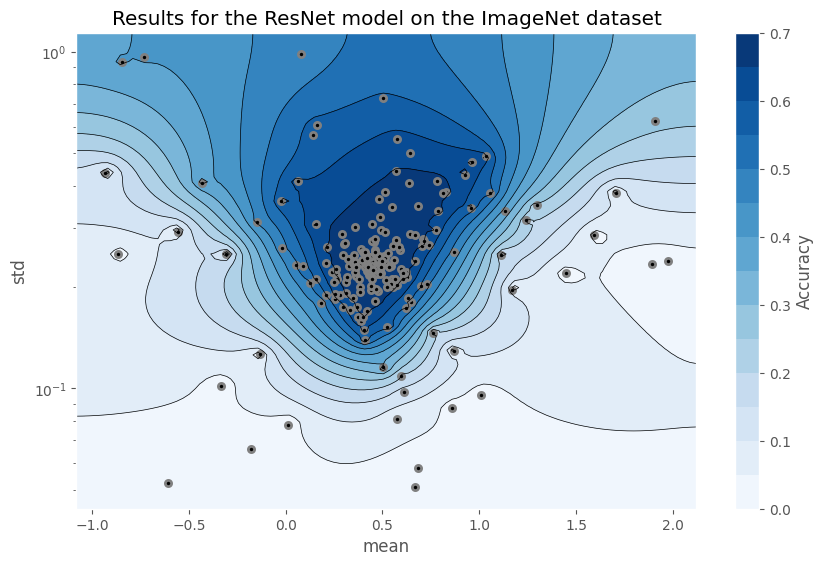

In [44]:
# https://optuna.readthedocs.io/en/stable/reference/visualization/matplotlib/generated/optuna.visualization.matplotlib.contour.html
from optuna.visualization.matplotlib import plot_contour

ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
ax.set_title('Results for the ResNet model on the ImageNet dataset')
fig = plt.gcf()
fig.set_size_inches(figsize[0], figsize[1])

In [45]:
def objective(trial):
    mean_R = trial.suggest_float('mean_R', -1, 2., log=False)
    mean_G = trial.suggest_float('mean_G', -1, 2., log=False)
    mean_B = trial.suggest_float('mean_B', -1, 2., log=False)
    std_R = trial.suggest_float('std_R', 0.05, 1., log=True)
    std_G = trial.suggest_float('std_G', 0.05, 1., log=True)
    std_B = trial.suggest_float('std_B', 0.05, 1., log=True)
    accuracy = main(mean_R, mean_G, mean_B, std_R, std_G, std_B, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model + '-RGB')
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'mean_R': 1.3298819797085812, 'mean_G': 1.158044524356995, 'mean_B': 0.8608253845142254, 'std_R': 0.5979328216633798, 'std_G': 0.5617464047018473, 'std_B': 0.4674990941714531}
Best value:  0.63608


/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_16226/1811433546.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
[W 2024-12-24 08:33:45,033] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_16226/1811433546.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
[W 2024-12-24 08:33:45,115] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_16226/1811433546.py:4: ExperimentalWarning:

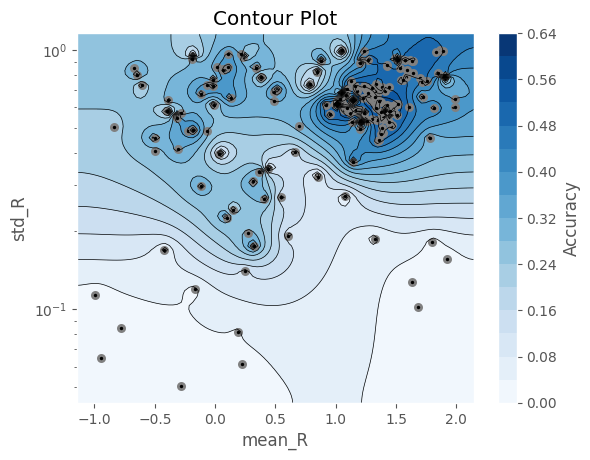

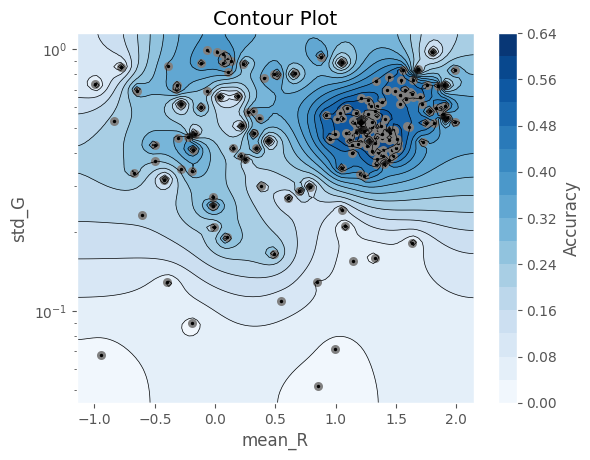

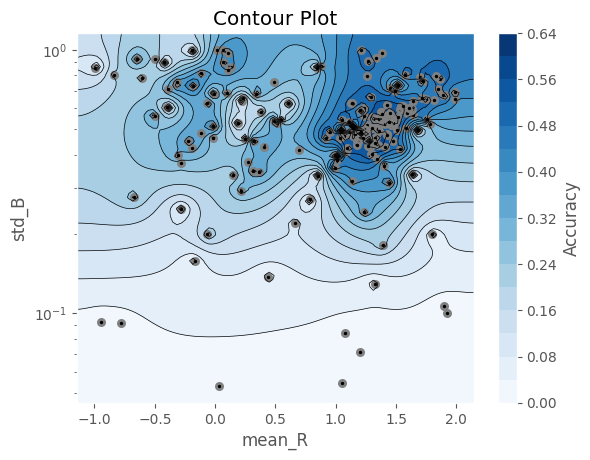

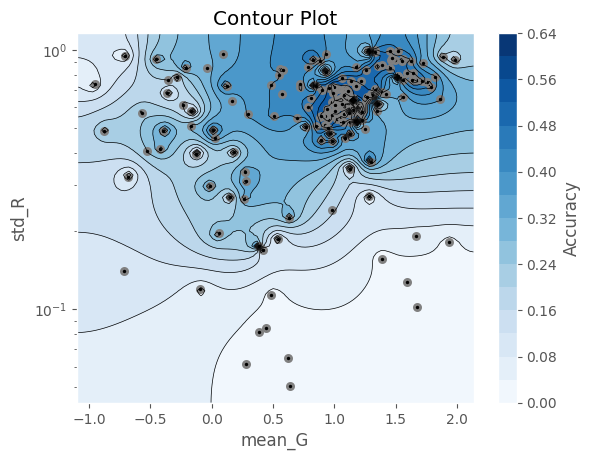

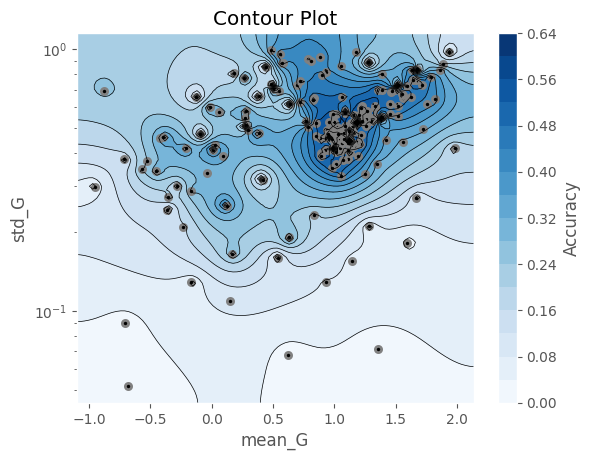

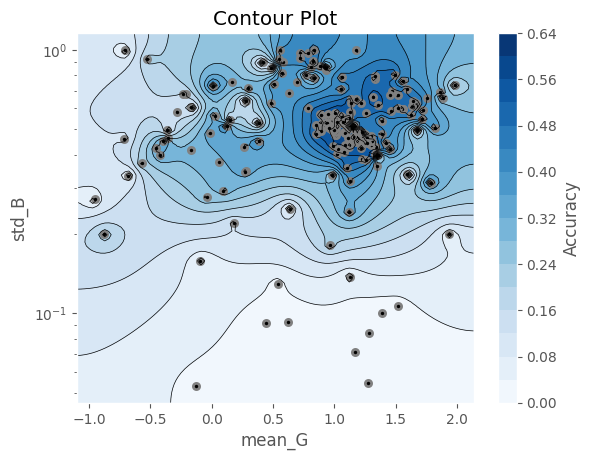

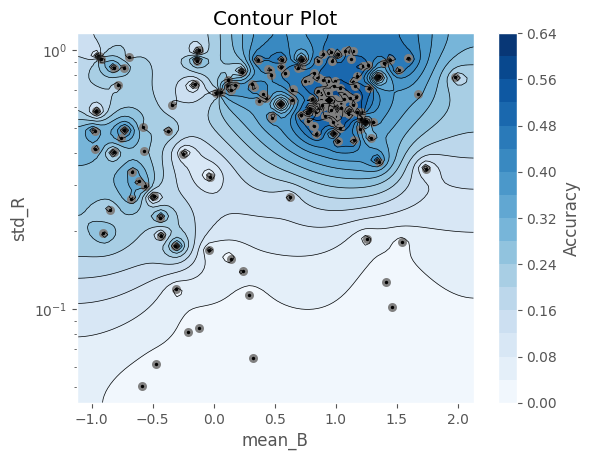

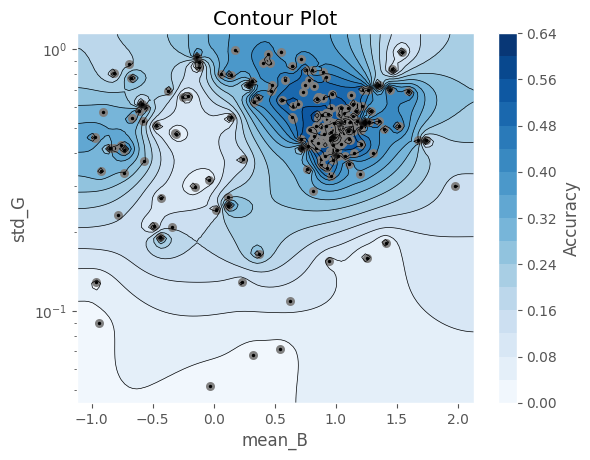

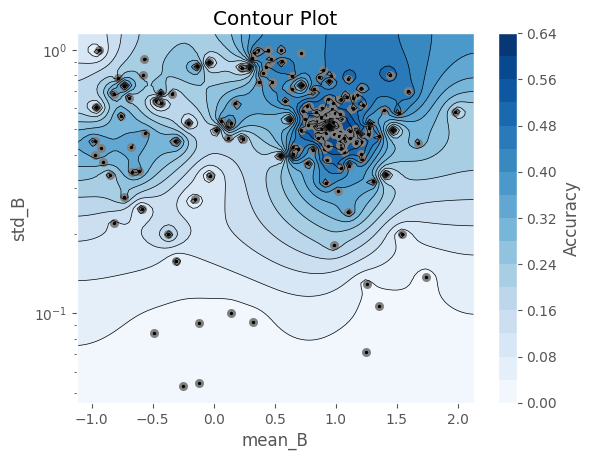

In [49]:
# fig, axs = plt.subplots(3, 3, figsize=figsize)
for i, c_mean in enumerate(['R', 'G', 'B']):
    for j, c_std in enumerate(['R', 'G', 'B']):
        ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
        # ax.set_title('Results for the ResNet model on the ImageNet dataset')

/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_16226/2013726993.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["mean_R", "mean_G", "mean_B", "std_R", "std_G", "std_B"])


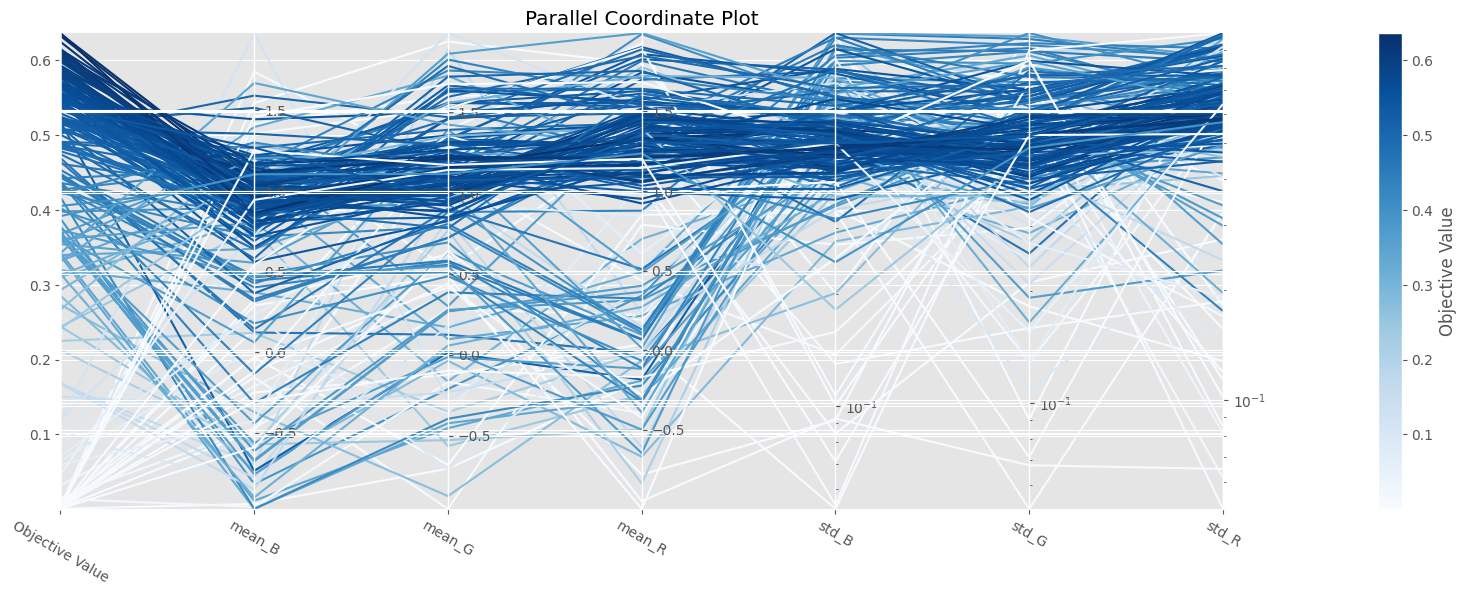

In [56]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["mean_R", "mean_G", "mean_B", "std_R", "std_G", "std_B"])
plt.gcf().set_size_inches(figsize[0]*2, figsize[1])

The problem being now, how do you visualize a 6 dimensional accuracy landscape ? Or rather, how do you validate that the accuracy is stable on a given area of that space ?


## some book keeping for the notebook

In [42]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,matplotlib,torch  -r -g -b

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.31.0

numpy     : 1.26.4
matplotlib: 3.10.0
torch     : 2.5.1

Compiler    : GCC 14.2.0
OS          : Linux
Release     : 6.11.0-13-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 24
Architecture: 64bit

Hostname: CONECT-LID-01

Git hash: 55485a0f637795ce4ade9afc461b5916623408f0

Git repo: https://github.com/laurentperrinet/2024-12-09-normalizing-images-in-convolutional-neural-networks.git

Git branch: main

